# Перцептрон для восприятия цифр
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать классический перцептрон, немного улучшить его, и протестировать результат на классической задаче определния цифр по изображениям.

In [81]:
import numpy as np
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import precision_score, recall_score, accuracy_score
import copy

### Задание 1 (3 балла)
Для начала реализуем простой перцептрон.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [251]:
class Perceptron:
    def __init__(self, iterations=100):
        self.w = None
        self.iterations = iterations
        self.cl_map = None
        self.rev_cl_map = None
    
    def fit(self, X, y):
        # map classes to -1 and 1
        classes = np.unique(y)
        self.cl_map = {classes[i]: [-1, 1][i] for i in range(2)}
        self.rev_cl_map = {[-1, 1][i]: classes[i] for i in range(2)}
        
        X = X.copy()
        X = np.insert(X, 0, values=1, axis=1)
        
#         self.w = np.random.randn(X.shape[1])
        self.w = np.zeros(X.shape[1])
    
        X_len = X.shape[0]
    
        for i in range(self.iterations):
            ni = i % X_len
            
            h = np.sign(X[ni].dot(self.w))
            yt = self.cl_map[y[ni]]
            
            if yt != h:
                self.w = self.w + yt * X[ni]
                
    def predict(self, X):
        X = X.copy()
        X = np.insert(X, 0, values=1, axis=1)
        
        y = np.sign(X.dot(self.w))
        y[y == 0] = 1
        
        f = lambda x: self.rev_cl_map[x]
        
        y = np.vectorize(f)(y)
        
        return y

In [323]:
def visualize(X, labels_true, labels_pred, w):
    unique_labels = np.unique(labels_true)
    unique_colors = dict([(l, c) for l, c in zip(unique_labels, [[0.8, 0., 0.], [0., 0., 0.8]])])
    plt.figure(figsize=(9, 9))

    if w[1] == 0:
        plt.plot([X[:, 0].min(), X[:, 0].max()], w[0] / w[2])
    elif w[2] == 0:
        plt.plot(w[0] / w[1], [X[:, 1].min(), X[:, 1].max()])  
    else:
        mins, maxs = X.min(axis=0), X.max(axis=0)
        pts = [[mins[0], -mins[0] * w[1] / w[2] - w[0] / w[2]],
               [maxs[0], -maxs[0] * w[1] / w[2] - w[0] / w[2]],
               [-mins[1] * w[2] / w[1] - w[0] / w[1], mins[1]],
               [-maxs[1] * w[2] / w[1] - w[0] / w[1], maxs[1]]]
        pts = [(x, y) for x, y in pts if mins[0] <= x <= maxs[0] and mins[1] <= y <= maxs[1]]
        x, y = list(zip(*pts))
        plt.plot(x, y, c=(0.75, 0.75, 0.75), linestyle="--")
    
    colors_inner = [unique_colors[l] for l in labels_true]
    colors_outer = [unique_colors[l] for l in labels_pred]
    plt.scatter(X[:, 0], X[:, 1], c=colors_inner, edgecolors=colors_outer)
    plt.show()

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

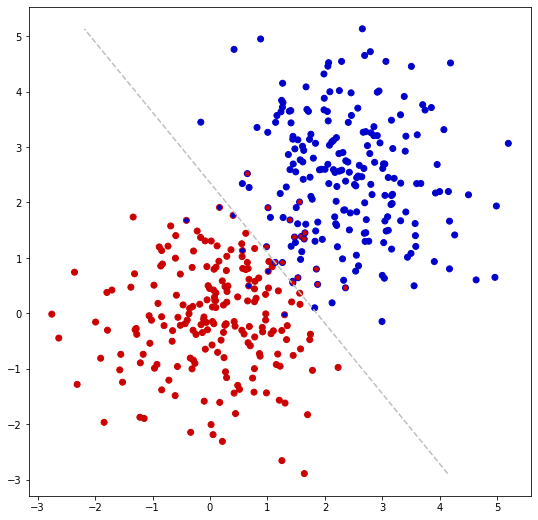

In [325]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

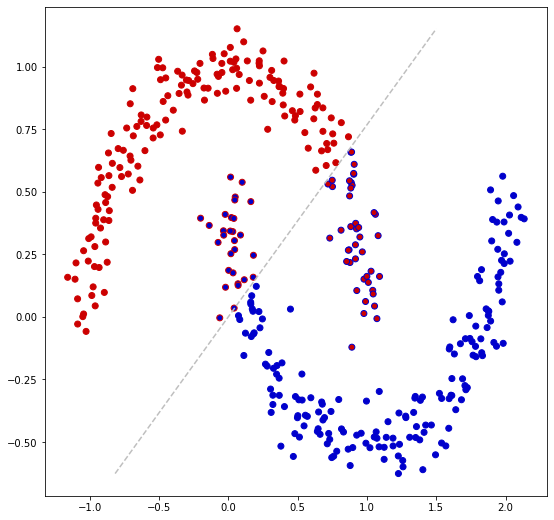

In [329]:
X, true_labels = make_moons(400, noise=0.075)
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### Задание 2 (2 балл)
Проблема обычной реализации перцептрона в том, что закончить его обучение мы можем с неоптимальными весами, т.к. точность разбиения в зависимости от числа итераций не растет монотонно. Чтобы этого избежать, мы можем оставлять в конце веса той итерации, на которой мы лучше всего разбивали множество `X`.

Реализуем перцептрон с карманом.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. В конце обучения оставляет лучшие веса. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [330]:
# для сравнения весов по умолчанию будем использовать accuracy
class PerceptronBest:
    def __init__(self, iterations=100, pocket_func=accuracy_score):
        self.w = None
        self.iterations = iterations
        self.cl_map = None
        self.rev_cl_map = None
        self.pocket_func = pocket_func
    
    def fit(self, X, y):
        # map classes to -1 and 1
        classes = np.unique(y)
        self.cl_map = {classes[i]: [-1, 1][i] for i in range(2)}
        self.rev_cl_map = {[-1, 1][i]: classes[i] for i in range(2)}
        
        X = X.copy()
        X = np.insert(X, 0, values=1, axis=1)
        
        self.w = np.zeros(X.shape[1])
    
        X_len = X.shape[0]
        
        best_score = 0
        best_w = self.w.copy()
    
        for i in range(self.iterations):
            ni = i % X_len
            
            h = np.sign(X[ni].dot(self.w))
            yt = self.cl_map[y[ni]]
            
            if yt != h:
                self.w = self.w + yt * X[ni]
                pred = self._calc_y(X)
                new_score = self.pocket_func(y, pred)
                
                if new_score > best_score:
                    best_score = new_score
                    best_w = self.w.copy()
        
        self.w = best_w
    
    def _calc_y(self, Xc):
        y = np.sign(Xc.dot(self.w))
        y[y == 0] = 1
        
        f = lambda x: self.rev_cl_map[x]
        
        y = np.vectorize(f)(y)
        
        return y
    
    def predict(self, X):
        X = X.copy()
        X = np.insert(X, 0, values=1, axis=1)
        return self._calc_y(X)

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

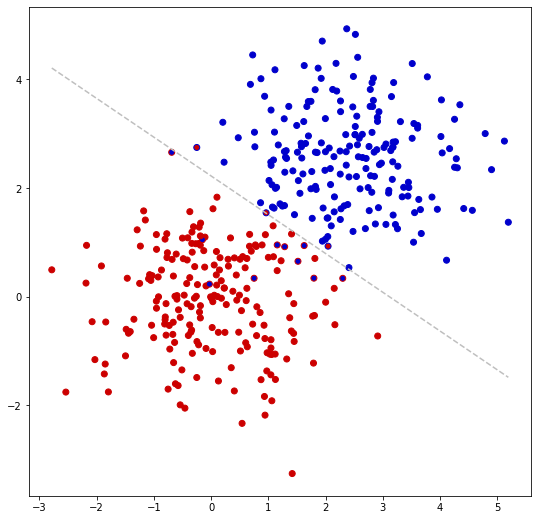

In [331]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

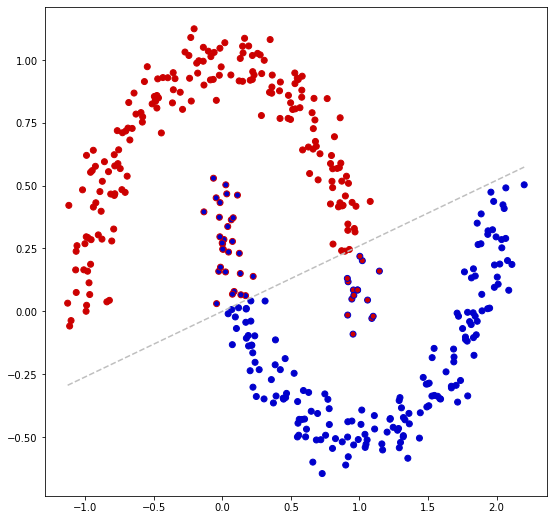

In [334]:
X, true_labels = make_moons(400, noise=0.075)
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### Задание 3 (1 балл)
Реализуйте метод `transform_images(images)`, который преобразует изображения в двумерные векторы. Значение компонент векторов придумайте сами и напишите в виде комментария к методу.

In [335]:
def transform_images(images):
    # берем значения пикселей по координатам 2, 4 и 4, 4
    X = [[image[2, 4], image[4, 4]] for image in images]

    return np.array(X)

def get_digits(y0=1, y1=5):
    data = datasets.load_digits()
    images, labels = data.images, data.target
    mask = np.logical_or(labels == y0, labels == y1)
    labels = labels[mask]
    images = images[mask]
    images /= np.max(images)
    X = transform_images(images)
    return X, labels

### Задание 4 (4 балла)
Теперь посмотрим на точность обычного перцептрона и перцептрона выбором лучшей итерации. Для тестирования будем использовать цифры 1 и 5. Необходимо использовать реализованное выше преобразование, т.е. только векторы из 2х признаков. 

Точность хотя бы одного из классификаторов на тестовой выборке должна быть больше 80%

In [336]:
X, y = get_digits()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

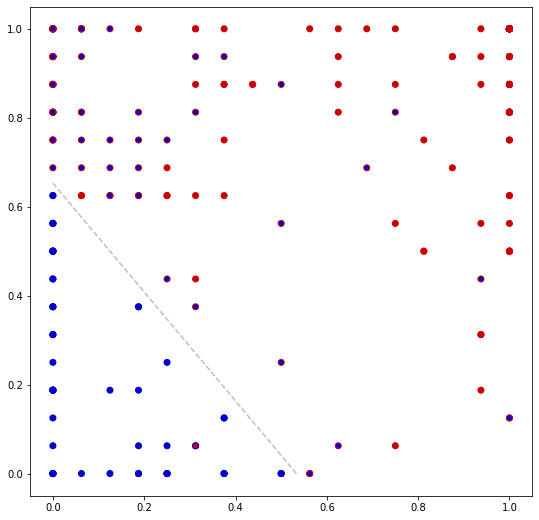

Accuracy: 0.8493150684931506


In [338]:
c = Perceptron(iterations=100000)
c.fit(X_train, y_train)
visualize(X_train, y_train, np.array(c.predict(X_train)), c.w)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

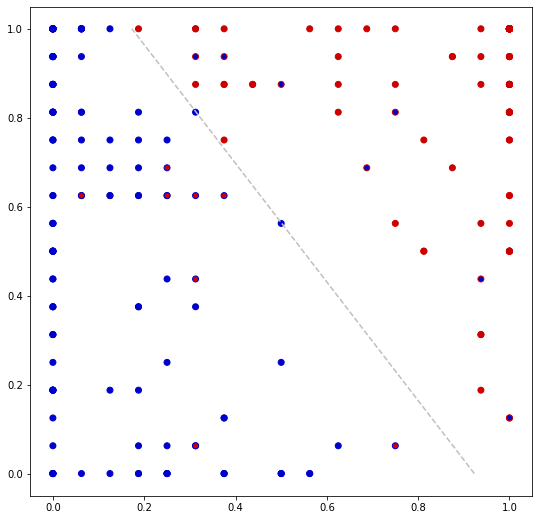

Accuracy: 0.9726027397260274


In [339]:
c = PerceptronBest(iterations=100000)
c.fit(X_train, y_train)
visualize(X_train, y_train, np.array(c.predict(X_train)), c.w)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

А теперь посчитаем среднюю точность по всем возможным парам цифр

In [340]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = get_digits(y0, y1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = Perceptron(iterations=20000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.741815955771837


In [341]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = get_digits(y0, y1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = PerceptronBest(iterations=20000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.8201615919089712
